In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Model(s)
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [2]:
stocks = pd.read_csv('/Users/jacobemerson/Code/my_projects/data/constituents.csv')

# Download Stock Data

In [3]:
tickers = list(stocks['Symbol'])
# tickers = ['AAPL', 'MSFT', 'GOOG']

In [4]:
def to_yahoo_ticker(t: str) -> str:
    # common US tickers with dot-class shares
    return t.replace(".", "-")

In [5]:
tickers_yf = [to_yahoo_ticker(t) for t in tickers]

In [6]:
start_date = "2018-01-01"
end_date = "2024-01-01"
# Download stock data from yfinance
raw_df = yf.download(
    tickers=tickers_yf,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=False
)

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}

4 Failed downloads:
['GEV', 'SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['WBA']: YFTzMissingError('possibly delisted; no timezone found')
['TFC']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [7]:
# # Build ticker -> industry mapping (one-time in-memory)
# industry_map = {
#     t: yf.Ticker(t).info.get("industry")
#     for t in tickers
# }

# industry_map = pd.Series(industry_map, name="industry")

In [8]:
# Build ticker -> sector mapping (one-time in-memory)
sector_map = {
    t: yf.Ticker(t).info.get("sector")
    for t in tickers
}

sector_map = pd.Series(sector_map, name="sector")


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}


# Restructure Dataframe

In [9]:
# Keep raw price fields only
price_cols = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
raw_df = raw_df.loc[:, price_cols]

In [10]:
# Reshape to long/tidy format
df = (
    raw_df
    .stack(level=1, future_stack=True)   # move Ticker to index
    .rename_axis(index=["date", "ticker"])
    .sort_index()
)


df["sector"]   = df.index.get_level_values("ticker").map(sector_map)
# df["industry"] = df.index.get_level_values("ticker").map(industry_map)

In [12]:
# Rename columns
df.rename(
    columns={
        "Adj Close": "adj_close",
        "Close": "close",
        "High": "high",
        "Low": "low",
        "Open": "open",
        "Volume": "volume"
    },
    inplace=True
)


In [13]:
# Convert to numeric and sort_index by date
df = df.apply(pd.to_numeric, errors="coerce")
df = df.sort_index(level=["date", "ticker"])


# Feature Engineering

In [14]:
# Create daily log returns feature
df["ret_1"] = (
    np.log(df["adj_close"])
    .groupby(level="ticker")
    .diff()
)

In [15]:
# Create dollar volume feature
df["dollar_volume"] = df["adj_close"] * df["volume"]


In [17]:
# Create 5, 21, 63 day momentum features
df["mom_5"]  = df.groupby(level="ticker")["ret_1"].rolling(5).sum().reset_index(level=0, drop=True)
df["mom_21"] = df.groupby(level="ticker")["ret_1"].rolling(21).sum().reset_index(level=0, drop=True)
df["mom_63"] = df.groupby(level="ticker")["ret_1"].rolling(63).sum().reset_index(level=0, drop=True)


In [19]:
# Create 252 day, 12-1 momentum features
df["mom_252"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              x.sort_index(level="date")["ret_1"]
               .rolling(252)
               .sum()
          )
      )
)

df["mom_252_21"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              x.sort_index(level="date")["ret_1"]
               .rolling(252)
               .sum()
               - x.sort_index(level="date")["ret_1"].rolling(21).sum()
          )
      )
)


In [20]:
# Create sharpe ratio feature
df["sharpe_60"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              x.sort_index(level="date")["ret_1"].rolling(60).mean()
              / (x.sort_index(level="date")["ret_1"].rolling(60).std(ddof=0) + 1e-9)
          )
      )
)

In [21]:
# Create 1, 5 Day Reversal Features
df["rev_1"] = -df["ret_1"]

df["rev_5"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              -x.sort_index(level="date")["ret_1"]
               .rolling(5)
               .sum()
          )
      )
)

In [22]:
# Create 20, 60 Day Volatility Features
df["vol_20"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              x.sort_index(level="date")["ret_1"]
               .rolling(20)
               .std(ddof=0)
          )
      )
)

df["vol_60"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              x.sort_index(level="date")["ret_1"]
               .rolling(60)
               .std(ddof=0)
          )
      )
)


In [23]:
# Create 14 Day Average True Range Feature
df["true_range"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              pd.concat(
                  [
                      (x.sort_index(level="date")["high"]
                       - x.sort_index(level="date")["low"]).abs(),

                      (x.sort_index(level="date")["high"]
                       - x.sort_index(level="date")["close"].shift(1)).abs(),

                      (x.sort_index(level="date")["low"]
                       - x.sort_index(level="date")["close"].shift(1)).abs(),
                  ],
                  axis=1
              ).max(axis=1)
          )
      )
)

df["atr_14"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              x.sort_index(level="date")["true_range"]
               .rolling(14)
               .mean()
          )
      )
)

df["atr_14_pct"] = df["atr_14"] / df["adj_close"]


In [24]:
# Create Average Daily Dollar Trading Volume and Amihud Illiquidity Features
df["log_dollar_vol_20"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              np.log(
                  x.sort_index(level="date")["dollar_volume"]
                   .rolling(20)
                   .mean()
              )
          )
      )
)

df["amihud_20"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              (x.sort_index(level="date")["ret_1"].abs()
               / x.sort_index(level="date")["dollar_volume"])
              .rolling(20)
              .mean()
          )
      )
)


In [25]:
# Create price action features: MA gap 20, RSI-14, high-low-20
df["ma_gap_20"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              x.sort_index(level="date")["adj_close"]
               .pipe(lambda s: (s - s.rolling(20).mean()) / s.rolling(20).mean())
          )
      )
)

df["rsi_14"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              x.sort_index(level="date")["adj_close"]
               .diff()
               .pipe(lambda d: (
                   100
                   - 100 / (
                       1
                       + d.clip(lower=0.0).ewm(alpha=1/14, adjust=False).mean()
                         / d.clip(upper=0.0).abs().ewm(alpha=1/14, adjust=False).mean()
                   )
               ))
          )
      )
)

df["high_low_20"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(
          lambda x: (
              (x.sort_index(level="date")["high"].rolling(20).max()
               - x.sort_index(level="date")["low"].rolling(20).min())
              / x.sort_index(level="date")["adj_close"]
          )
      )
)


In [26]:
# Create size features: log market cap, market beta (60-day vs SPY)

# Calculate log market cap
tickers = df.index.get_level_values("ticker").unique()

shares_out = {
    t: (yf.Ticker(t).info.get("sharesOutstanding") or np.nan)
    for t in tickers
}
shares_out = pd.Series(shares_out)

df = df.reset_index()
df["log_mkt_cap"] = np.log(df["adj_close"] * df["ticker"].map(shares_out))
df = df.set_index(["date", "ticker"]).sort_index()

# Calculate Market Beta
spy_df = yf.download(
    tickers="SPY",
    start=df.index.get_level_values("date").min(),
    end=df.index.get_level_values("date").max(),
    auto_adjust=False,
    progress=False
)

spy_series = spy_df["Adj Close"].dropna()
spy_ret = np.log(spy_series / spy_series.shift(1)).sort_index()

dates = df.index.get_level_values("date")
df["spy_ret_1"] = spy_ret.reindex(dates).to_numpy()


df["beta_60"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(lambda x: (
          x.sort_index(level="date")["ret_1"]
           .rolling(60)
           .cov(x.sort_index(level="date")["spy_ret_1"])
          / x.sort_index(level="date")["spy_ret_1"].rolling(60).var(ddof=0)
      ))
)

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}


In [27]:
# Create target variable
df["fwd_ret_1"] = (
    df.groupby(level="ticker", group_keys=False)
      .apply(lambda x: x.sort_index(level="date")["ret_1"].shift(-1))
)


In [28]:
eps = 1e-8  # numerical safety

df["fwd_ret_1_vol_scaled"] = df["fwd_ret_1"] / (df["vol_20"] + eps)


In [29]:
df["y_vol_scaled"] = (
    df.groupby(level="date")["fwd_ret_1_vol_scaled"]
      .transform(lambda x: (x - x.mean()) / x.std())
)

# Cleaning, Standardizing, Neutralizing

In [30]:
# Winsorize features
def winsorize_feat(
    df: pd.DataFrame,
    feature_names: list[str],
    lower_q: float = 0.01,
    upper_q: float = 0.99
) -> pd.DataFrame:

    # work on a copy
    df = df.copy()

    for feat in feature_names:
        # ensure feature exists
        if feat not in df.columns:
            raise KeyError(f"Feature '{feat}' not found in df.")

        # convert to numeric
        s = pd.to_numeric(df[feat], errors="coerce")

        # compute cross-sectional bounds per date
        lo = s.groupby(level="date").quantile(lower_q)
        hi = s.groupby(level="date").quantile(upper_q)

        # clip values using date alignment
        df[feat] = s.clip(
            lower=lo.reindex(df.index.get_level_values("date")).to_numpy(),
            upper=hi.reindex(df.index.get_level_values("date")).to_numpy()
        )

    return df


In [31]:
# Select features for winsorizer
winsorize_features = [
    "mom_5",
    "mom_21",
    "mom_63",
    "mom_252",
    "mom_252_21",
    "sharpe_60",
    "rev_1",
    "rev_5",
    "vol_20",
    "vol_60",
    "atr_14_pct",
    "log_dollar_vol_20",
    "amihud_20",
    "ma_gap_20",
    "rsi_14",
    "high_low_20",
    "beta_60",
]


# Call winsorize function
df_wins = winsorize_feat(
    df=df,
    feature_names=winsorize_features,
    lower_q=0.01,
    upper_q=0.99
)


In [32]:
def z_score(df: pd.DataFrame, feats: list[str], eps: float = 1e-12) -> pd.DataFrame:
    df = df[feats].copy()
    dates = df.index.get_level_values("date")

    for f in feats:
        g = df[f].groupby(level="date")
        mean = g.mean()
        std = g.std(ddof=0)

        mean_aligned = mean.reindex(dates).to_numpy()
        std_aligned  = std.reindex(dates).to_numpy()

        z = (df[f].to_numpy() - mean_aligned) / np.where(
            std_aligned > eps, std_aligned, np.nan
        )

        df[f] = z

    return df


In [33]:
z_features = [
    # Alpha features (model inputs)
    "mom_5",
    "mom_21",
    "mom_63",
    "mom_252_21",
    "sharpe_60",
    "rev_1",
    "rev_5",
    "vol_20",
    "vol_60",
    "atr_14_pct",
    "log_dollar_vol_20",
    "amihud_20",
    "ma_gap_20",
    "rsi_14",
    "high_low_20",

    # Control features (z-scored, NOT model inputs)
    "log_mkt_cap",
    "beta_60",
]

df_z = z_score(df_wins, z_features)

In [34]:
def drop_na_per_day(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df
        .groupby(level=0, group_keys=False)
        .apply(lambda x: x.dropna(how="any"))
    )


In [35]:
df_z = drop_na_per_day(df_z)

In [36]:
# df_z["fwd_ret_1"] = df["fwd_ret_1"]

In [37]:
df_z["y_vol_scaled"] = df["y_vol_scaled"]

In [38]:
df_final = df_z.drop(columns=["log_mkt_cap"])

In [39]:
# def test_train_split(df: pd.DataFrame, label_col: str):
#     data = df.copy()

#     # Ensure date index level is datetime
#     data.index = data.index.set_levels(
#         [pd.to_datetime(data.index.levels[0]), data.index.levels[1]],
#         level=["date", "ticker"]
#     )

#     # Drop last date (t+1 label safety)
#     last_date = data.index.get_level_values("date").max()
#     data = data[data.index.get_level_values("date") < last_date]

#     # Option B ranges
#     train_start, train_end = pd.Timestamp("2018-01-02"), pd.Timestamp("2021-12-31")
#     val_start,   val_end   = pd.Timestamp("2022-01-03"), pd.Timestamp("2022-12-30")
#     test_start,  test_end  = pd.Timestamp("2023-01-03"), pd.Timestamp("2023-12-27")

#     d = data.index.get_level_values("date")
#     train = data[(d >= train_start) & (d <= train_end)]
#     val   = data[(d >= val_start)   & (d <= val_end)]
#     test  = data[(d >= test_start)  & (d <= test_end)]

#     # Resolve label column (supports normal columns or MultiIndex columns)
#     y_col = None

#     if label_col in train.columns:
#         y_col = label_col
#     elif isinstance(train.columns, pd.MultiIndex):
#         matches = [c for c in train.columns if str(c[-1]) == label_col]
#         if len(matches) == 1:
#             y_col = matches[0]
#         elif len(matches) > 1:
#             raise KeyError(
#                 f"Multiple columns match label_col='{label_col}' in last level: {matches[:10]} ..."
#             )
#     if y_col is None:
#         # helpful debugging output
#         cols_preview = train.columns.tolist()[:50]
#         raise KeyError(
#             f"Label '{label_col}' not found in columns. "
#             f"Example columns: {cols_preview}"
#         )

#     # Split features / label
#     X_train, y_train = train.drop(columns=[y_col]), train[y_col]
#     X_val,   y_val   = val.drop(columns=[y_col]),   val[y_col]
#     X_test,  y_test  = test.drop(columns=[y_col]),  test[y_col]

#     return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
# def test_train_split(
#     df: pd.DataFrame,
#     label_col: str,
#     start_date: str | pd.Timestamp,
#     end_date: str | pd.Timestamp,
# ):
#     """
#     Daily cross-sectional train/val/test split.

#     Assumptions:
#       - df.index is MultiIndex ['date','ticker']
#       - start_date / end_date define the full data window (yfinance-style)
#       - Uses fixed relative windows:
#           Train: 4 years
#           Val  : 1 year
#           Test : last 1 year
#     """

#     data = df.copy()

#     # Ensure MultiIndex structure
#     if not isinstance(data.index, pd.MultiIndex) or data.index.names[:2] != ["date", "ticker"]:
#         raise ValueError("df.index must be a MultiIndex with names ['date','ticker']")

#     # Ensure datetime date level
#     data.index = data.index.set_levels(
#         [pd.to_datetime(data.index.levels[0]), data.index.levels[1]],
#         level=["date", "ticker"]
#     )

#     start_date = pd.Timestamp(start_date)
#     end_date   = pd.Timestamp(end_date)

#     # Restrict to requested date window
#     d = data.index.get_level_values("date")
#     data = data[(d >= start_date) & (d <= end_date)]

#     # Drop last available date (t+1 label safety)
#     last_date = data.index.get_level_values("date").max()
#     data = data[data.index.get_level_values("date") < last_date]

#     # --- Define split boundaries (relative to end_date) ---
#     test_end   = data.index.get_level_values("date").max()
#     test_start = test_end - pd.DateOffset(years=1)

#     val_end    = test_start - pd.Timedelta(days=1)
#     val_start  = val_end - pd.DateOffset(years=1)

#     train_end  = val_start - pd.Timedelta(days=1)
#     train_start = train_end - pd.DateOffset(years=4)

#     # Apply splits
#     d = data.index.get_level_values("date")

#     train = data[(d >= train_start) & (d <= train_end)]
#     val   = data[(d >= val_start)   & (d <= val_end)]
#     test  = data[(d >= test_start)  & (d <= test_end)]

#     # Sanity checks
#     for name, part in [("train", train), ("val", val), ("test", test)]:
#         if part.empty:
#             raise ValueError(f"{name} split is empty. Check start_date/end_date and data coverage.")

#     # Resolve label column (normal or MultiIndex columns)
#     y_col = None
#     if label_col in train.columns:
#         y_col = label_col
#     elif isinstance(train.columns, pd.MultiIndex):
#         matches = [c for c in train.columns if str(c[-1]) == label_col]
#         if len(matches) == 1:
#             y_col = matches[0]
#         elif len(matches) > 1:
#             raise KeyError(
#                 f"Multiple columns match label_col='{label_col}' in last level: {matches[:10]} ..."
#             )

#     if y_col is None:
#         cols_preview = train.columns.tolist()[:50]
#         raise KeyError(
#             f"Label '{label_col}' not found in columns. Example columns: {cols_preview}"
#         )

#     # Split features / label
#     X_train, y_train = train.drop(columns=[y_col]), train[y_col]
#     X_val,   y_val   = val.drop(columns=[y_col]),   val[y_col]
#     X_test,  y_test  = test.drop(columns=[y_col]),  test[y_col]

#     return X_train, y_train, X_val, y_val, X_test, y_test


In [41]:
def test_train_split(
    df: pd.DataFrame,
    label_col: str,
    start_date: str | pd.Timestamp,
    end_date: str | pd.Timestamp,
    train_years: int = 4,
    val_years: int = 1,
    test_years: int = 1,
):
    """
    Calendar-year train/val/test split for daily cross-sectional models.

    Example (data through early 2024):
      Test: 2023
      Val : 2022
      Train: 2018-2021  (train_years=4)

    This avoids "drifting" DateOffset boundaries that can shift starts to 2019.
    """

    data = df.copy()

    # Ensure MultiIndex structure
    if not isinstance(data.index, pd.MultiIndex) or data.index.names[:2] != ["date", "ticker"]:
        raise ValueError("df.index must be a MultiIndex with names ['date','ticker']")

    # Ensure datetime date level
    data.index = data.index.set_levels(
        [pd.to_datetime(data.index.levels[0]), data.index.levels[1]],
        level=["date", "ticker"]
    )

    start_date = pd.Timestamp(start_date)
    end_date   = pd.Timestamp(end_date)

    # Restrict to requested date window
    d = data.index.get_level_values("date")
    data = data[(d >= start_date) & (d <= end_date)]
    if data.empty:
        raise ValueError("No data in the requested [start_date, end_date] window.")

    # Drop last available date (t+1 label safety)
    max_date = data.index.get_level_values("date").max()
    data = data[data.index.get_level_values("date") < max_date]
    if data.empty:
        raise ValueError("Data became empty after dropping last date for label safety.")

    # Recompute max date after dropping
    max_date = data.index.get_level_values("date").max()

    # Pick the last COMPLETE calendar year in the data
    # If max_date is not in December, the current year is partial -> use previous year.
    last_full_year = max_date.year if max_date.month == 12 else (max_date.year - 1)

    test_start_year = last_full_year - (test_years - 1)
    val_start_year  = test_start_year - val_years
    train_start_year = val_start_year - train_years

    # Calendar boundaries
    test_start  = pd.Timestamp(f"{test_start_year}-01-01")
    test_end    = pd.Timestamp(f"{last_full_year}-12-31")

    val_start   = pd.Timestamp(f"{val_start_year}-01-01")
    val_end     = pd.Timestamp(f"{test_start_year - 1}-12-31")

    train_start = pd.Timestamp(f"{train_start_year}-01-01")
    train_end   = pd.Timestamp(f"{val_start_year - 1}-12-31")

    # Apply splits (clipped to available dates automatically by filtering)
    d = data.index.get_level_values("date")
    train = data[(d >= train_start) & (d <= train_end)]
    val   = data[(d >= val_start)   & (d <= val_end)]
    test  = data[(d >= test_start)  & (d <= test_end)]

    # Sanity checks with helpful debug
    def _minmax(x):
        if x.empty:
            return None, None
        dd = x.index.get_level_values("date")
        return dd.min().date(), dd.max().date()

    for name, part, s, e in [
        ("train", train, train_start, train_end),
        ("val",   val,   val_start,   val_end),
        ("test",  test,  test_start,  test_end),
    ]:
        if part.empty:
            raise ValueError(
                f"{name} split is empty.\n"
                f"Requested {name} range: {s.date()} .. {e.date()}\n"
                f"Available data range   : {d.min().date()} .. {d.max().date()}\n"
                f"Common cause: features/labels require lookback and dropped early dates."
            )

    # Resolve label column (normal or MultiIndex columns)
    y_col = None
    if label_col in train.columns:
        y_col = label_col
    elif isinstance(train.columns, pd.MultiIndex):
        matches = [c for c in train.columns if str(c[-1]) == label_col]
        if len(matches) == 1:
            y_col = matches[0]
        elif len(matches) > 1:
            raise KeyError(
                f"Multiple columns match label_col='{label_col}' in last level: {matches[:10]} ..."
            )

    if y_col is None:
        cols_preview = train.columns.tolist()[:50]
        raise KeyError(
            f"Label '{label_col}' not found in columns. Example columns: {cols_preview}"
        )

    # Split features / label
    X_train, y_train = train.drop(columns=[y_col]), train[y_col]
    X_val,   y_val   = val.drop(columns=[y_col]),   val[y_col]
    X_test,  y_test  = test.drop(columns=[y_col]),  test[y_col]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [42]:
X_train, y_train, X_val, y_val, X_test, y_test = test_train_split(
    df_final,
    label_col="y_vol_scaled",
    start_date=start_date,
    end_date=end_date,
)


In [43]:
def extract_beta_60(df: pd.DataFrame) -> pd.DataFrame:
    if "beta_60" not in df.columns:
        raise KeyError("Column 'beta_60' not found in DataFrame")

    return df[["beta_60"]].copy()


In [44]:
X_train_beta = extract_beta_60(X_train)
X_val_beta   = extract_beta_60(X_val)
X_test_beta  = extract_beta_60(X_test)

In [45]:
def drop_beta_60(df):
    return df.drop(columns=["beta_60"], errors="ignore")

In [46]:
X_train = drop_beta_60(X_train)
X_val   = drop_beta_60(X_val)
X_test  = drop_beta_60(X_test)


In [ ]:
# rows = X_train.shape[0]  + X_val.shape[0] + X_test.shape[0]

In [ ]:
# X_train.shape[0]

365722

In [ ]:
# (X_train.shape[0]/rows)*100, (X_val.shape[0]/rows)*100, (X_test.shape[0]/rows)*100

(59.72180490417652, 20.232504213097833, 20.045690882725644)

# Model Selection

## Ridge

In [50]:
# ridge_model = Pipeline([
#     ("scaler", StandardScaler(with_mean=False)),  # features already CS-zscored
#     ("ridge", Ridge(alpha=10.0))
# ])

In [51]:
# # FIT
# ridge_model.fit(X_train, y_train)

# # PREDICT
# y_val_pred = ridge_model.predict(X_val)

# # BUILD VALIDATION DF (ONLY actual vs predicted)
# val_df_rdg = pd.DataFrame(
#     {
#         "y_val": y_val.values,
#         "y_val_pred": y_val_pred,
#     },
#     index=y_val.index,   # keeps (date, ticker) alignment
# )

# val_df_rdg.head()

In [52]:
# def neutralize(pred, exposure):
#     # pred: 1D array-like
#     # exposure: 1D array-like
#     y = np.asarray(pred).reshape(-1, 1)
#     X = np.asarray(exposure).reshape(-1, 1)  # <-- make 2D
    
#     # Optional: add intercept
#     X = np.column_stack([np.ones(len(X)), X])

#     coef = np.linalg.lstsq(X, y, rcond=None)[0]
#     y_hat = X @ coef
#     resid = y - y_hat
#     return resid.ravel()

In [53]:
# Align beta_60 to the validation dataframe by index
# beta_val = df_z.loc[val_df_rdg.index, "beta_60"]

# val_df_rdg["y_val_pred_neut"] = neutralize(val_df_rdg["y_val_pred"], beta_val)

In [54]:
def neutralize_by_date(
    df: pd.DataFrame,
    pred_col: str = "y_val_pred",
    exposure: pd.Series | pd.DataFrame | None = None,
    exposure_col: str = "beta_60",
    out_col: str = "y_val_pred_neut",
    add_intercept: bool = True,
    ridge: float = 1e-6,
    winsorize_pct: float | None = 0.01,   # set None to disable
    min_names: int = 30,                  # skip dates with too few stocks
) -> pd.DataFrame:
    """
    Cross-sectional neutralization PER DATE for a MultiIndex (date, ticker) df.

    - Fits (per date): pred ~ intercept + exposure(s)  (weighted ridge-ready)
    - Returns residuals aligned to df.index in out_col.

    Parameters
    ----------
    df : DataFrame with MultiIndex ['date','ticker'].
    pred_col : prediction column to neutralize.
    exposure : Series/DataFrame aligned to df.index. If None, uses df[exposure_col].
               Example: exposure = df_z.loc[val_df_rdg.index, "beta_60"]
    exposure_col : used only when exposure is None.
    out_col : output column name.
    add_intercept : include intercept in regression.
    ridge : small L2 penalty for numerical stability (does not penalize intercept).
    winsorize_pct : cross-sectional winsorization level per date (e.g., 0.01 = 1%/99%).
    min_names : minimum number of names per date to run regression.

    Notes
    -----
    - This function neutralizes by date because it runs a separate regression inside each date group.
    - Supports multiple exposures if `exposure` is a DataFrame (N x K).
    """

    if not isinstance(df.index, pd.MultiIndex) or df.index.names[:2] != ["date", "ticker"]:
        raise ValueError("df.index must be a MultiIndex with names ['date','ticker']")

    if pred_col not in df.columns:
        raise KeyError(f"'{pred_col}' not found in df.columns")

    # Pull exposures, aligned to df.index
    if exposure is None:
        if exposure_col not in df.columns:
            raise KeyError(f"'{exposure_col}' not found in df.columns and exposure=None")
        expo = df[[exposure_col]].copy()
    else:
        if isinstance(exposure, pd.Series):
            expo = exposure.reindex(df.index).to_frame(exposure.name or exposure_col)
        else:
            expo = exposure.reindex(df.index).copy()

    # Build a working frame
    work = pd.concat([df[[pred_col]], expo], axis=1)

    # Helper: winsorize per date (optional)
    def _winsorize_group(g: pd.DataFrame) -> pd.DataFrame:
        if winsorize_pct is None or winsorize_pct <= 0:
            return g
        lo = g.quantile(winsorize_pct)
        hi = g.quantile(1 - winsorize_pct)
        return g.clip(lo, hi, axis=1)

    # Core: neutralize one date cross-section
    def _neutralize_one_date(g: pd.DataFrame) -> pd.Series:
        # Require enough names
        if len(g) < min_names:
            return pd.Series(index=g.index, data=np.nan)

        # Drop rows with NaNs in pred or exposures
        g2 = g.dropna()
        if len(g2) < min_names:
            return pd.Series(index=g.index, data=np.nan)

        # Winsorize pred + exposures inside the date
        g2_w = _winsorize_group(g2)

        y = g2_w[pred_col].to_numpy(dtype=float).reshape(-1, 1)
        X = g2_w.drop(columns=[pred_col]).to_numpy(dtype=float)

        # Ensure 2D exposures
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        n = X.shape[0]
        if add_intercept:
            X = np.column_stack([np.ones(n), X])

        # Ridge solve: (X'X + λI)β = X'y
        XtX = X.T @ X
        reg = ridge * np.eye(XtX.shape[0])
        if add_intercept:
            reg[0, 0] = 0.0  # don't penalize intercept

        beta = np.linalg.solve(XtX + reg, X.T @ y)
        resid = (y - X @ beta).ravel()

        # Return residuals aligned to original group index (NaN where dropped)
        out = pd.Series(index=g.index, data=np.nan, dtype=float)
        out.loc[g2_w.index] = resid
        return out

    # Apply per date
    neut = work.groupby(level="date", group_keys=False).apply(_neutralize_one_date)

    # Attach to df
    out_df = df.copy() 
    out_df[out_col] = neut
    return out_df


In [55]:
# idx = val_df_rdg.index

# # one-hot sector aligned to idx
# sector_dummies = pd.get_dummies(
#     df.loc[idx, "sector"],
#     prefix="sec",
#     dtype=float
# )

# exposures = pd.concat([
#     df_z.loc[idx, ["beta_60", "log_mkt_cap", "log_dollar_vol_20", "vol_20"]],
#     sector_dummies.loc[idx]  # one-hot
# ], axis=1)


In [56]:
# # df example: val_df_rdg with MultiIndex (date, ticker)
# # beta_val = df_z.loc[val_df_rdg.index, "beta_60"]

# val_df_rdg = neutralize_by_date(
#     val_df_rdg,
#     pred_col="y_val_pred",
#     exposure=beta_val,          # <- your Series
#     out_col="y_val_pred_neut",
#     ridge=1e-6,
#     winsorize_pct=0.01,
# )

In [57]:
# val_df_rdg.head()

## Evaluation

In [58]:
def daily_rank_ic(df, pred_col, target_col):
    return (
        df.groupby("date")
          .apply(lambda x: x[pred_col].corr(x[target_col], method="spearman"))
          .dropna()
    )

In [59]:
# ic_scores_rdg = pd.DataFrame(daily_rank_ic(val_df_rdg, "y_val_pred", "y_val"), columns=["ic_scores"])

In [60]:
# ic_scores_rdg.to_csv("ic_scores_rdg.csv", index=True)

In [61]:
# ic_scores_rdg

## LightGBM

In [62]:
lgb_params = {
    "objective": "regression",
    "learning_rate": 0.03,
    "num_leaves": 31,
    "max_depth": 5,
    "min_data_in_leaf": 200,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "lambda_l1": 1.0,
    "lambda_l2": 5.0,
    "verbosity": -1
}

In [63]:
train_set = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
val_set   = lgb.Dataset(X_val,   label=y_val,   free_raw_data=False)

In [64]:
# --- Train with early stopping on validation ---
lgb_model = lgb.train(
    params=lgb_params,
    train_set=train_set,
    num_boost_round=5000,
    valid_sets=[val_set],
    valid_names=["val"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=0),
    ],
)


In [65]:
# --- Predict ---
y_val_pred  = lgb_model.predict(X_val,  num_iteration=lgb_model.best_iteration)

In [66]:
# BUILD VALIDATION DF (ONLY actual vs predicted)
val_df_lgb = pd.DataFrame(
    {
        "y_val": y_val.values,
        "y_val_pred": y_val_pred,
    },
    index=y_val.index,   # keeps (date, ticker) alignment
)

In [67]:
# 1) Align beta_60 to the validation dataframe index (same rows, same order)
beta_val = df_z.loc[val_df_lgb.index, "beta_60"]

# # 2) Neutralize predictions vs beta_60 (single exposure)
# val_df_lgb["y_val_pred_neut"] = neutralize(val_df_lgb["y_val_pred"], beta_val)

In [68]:
idx = val_df_lgb.index

# one-hot sector aligned to idx
sector_dummies = pd.get_dummies(
    df.loc[idx, "sector"],
    prefix="sec",
    dtype=float
)

exposures = pd.concat([
    df_z.loc[idx, ["beta_60", "log_mkt_cap", "log_dollar_vol_20", "vol_20"]],
    sector_dummies.loc[idx]  # one-hot
], axis=1)

In [69]:
val_df_lgb = neutralize_by_date(
    val_df_lgb,
    pred_col="y_val_pred",
    exposure=exposures,          # <- your Series
    out_col="y_val_pred_neut",
    ridge=1e-6,
    winsorize_pct=0.01,
)

## Evaluation

In [70]:
ic_scores_lgb = pd.DataFrame(daily_rank_ic(val_df_lgb, "y_val_pred", "y_val"), columns=["ic_scores"])

In [71]:
ic_scores_lgb = (
    daily_rank_ic(val_df_lgb, "y_val_pred_neut", "y_val")
    .to_frame(name="ic_scores")
)


In [72]:
ic_scores_lgb

,ic_scores
date,
2022-01-03,-0.250720
2022-01-04,-0.188715
2022-01-05,-0.137111
2022-01-06,-0.243189
2022-01-07,0.008871
...,...
2022-12-23,-0.163961
2022-12-27,0.180520
2022-12-28,-0.011221


In [73]:
ic_scores_lgb.to_csv("ic_scores_lgb.csv", index=True)

In [74]:
ic_scores_lgb 

,ic_scores
date,
2022-01-03,-0.250720
2022-01-04,-0.188715
2022-01-05,-0.137111
2022-01-06,-0.243189
2022-01-07,0.008871
...,...
2022-12-23,-0.163961
2022-12-27,0.180520
2022-12-28,-0.011221


# Appendix

In [75]:
def plot_stock_price_train_window(
    df: pd.DataFrame,
    ticker: str,
    start_date: str | pd.Timestamp,
    end_date: str | pd.Timestamp,
    price_col: str = "adj_close",
    val_years: int = 1,
    test_years: int = 1,
):
    if not isinstance(df.index, pd.MultiIndex) or df.index.names[:2] != ["date", "ticker"]:
        raise ValueError("df.index must be a MultiIndex with names ['date','ticker']")

    df = df.copy()
    df.index = df.index.set_levels(pd.to_datetime(df.index.levels[0]), level="date")

    start_date, end_date = pd.Timestamp(start_date), pd.Timestamp(end_date)
    d = df.index.get_level_values("date")
    df = df[(d >= start_date) & (d <= end_date)]
    if df.empty:
        raise ValueError("No data in the provided date window.")

    train_end = d.max() - pd.DateOffset(years=val_years + test_years) - pd.Timedelta(days=2)

    g = df.xs(ticker, level="ticker")
    g = g[(g.index >= start_date) & (g.index <= train_end)]
    if g.empty:
        raise ValueError(f"No data for {ticker} in the training window.")

    ax = g[price_col].plot()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))
    plt.xticks(rotation=-45)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{ticker} Stock Price: {start_date.date()} → {train_end.date()}")
    plt.tight_layout()
    plt.show()


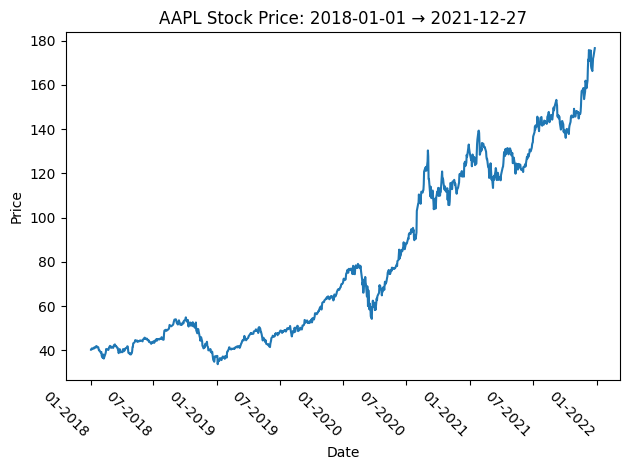

In [76]:
plot_stock_price_train_window(
    df,
    ticker="AAPL",
    start_date=start_date,
    end_date=end_date
)

In [77]:
X_train 

Price                 mom_5    mom_21    mom_63  mom_252_21  sharpe_60  \
date       ticker                                                        
2019-01-03 A      -0.990470 -0.232269  0.338036    0.168045   0.378040   
           AAPL   -2.920374 -1.817922 -2.359830    0.058055  -1.762791   
           ABBV   -0.938020  0.479268  0.682553   -0.199917   0.583892   
           ABT    -1.634752  0.095221  0.475407    0.975745   0.545027   
           ACGL    0.029203  0.214692  0.258125   -0.307893  -0.106680   
...                     ...       ...       ...         ...        ...   
2021-12-31 XYZ    -2.658610 -3.737154 -3.018551   -1.285529  -2.328121   
           YUM     0.552470  0.803605  0.376466   -0.131307   0.976726   
           ZBH    -0.633239 -0.194513 -1.947751   -1.894061  -1.815889   
           ZBRA    0.352072 -0.814648  0.645662    1.087494   0.490219   
           ZTS    -0.432364  0.561296  1.198952    0.524624   2.194704   

Price                 rev_1     rev_5    vol_20    vol_60  atr_14_pct  \
date       ticker                                                       
2019-01-03 A       0.789778  0.990470 -0.357784  0.046677   -0.380553   
           AAPL    3.379538  2.920374  1.661804  0.961910    0.798735   
           ABBV    0.602415  0.938020 -0.038259  0.055484    1.154045   
           ABT     1.292059  1.634752  0.307751 -0.331714   -0.059145   
           ACGL   -0.221263 -0.029203 -0.905095 -1.025029   -0.855688   
...                     ...       ...       ...       ...         ...   
2021-12-31 XYZ     3.020154  2.658610  2.646582  2.081236    3.054077   
           YUM    -0.417670 -0.552470 -0.762906 -1.217932   -1.291127   
           ZBH     1.251552  0.633239  0.068774  0.212099    0.013398   
           ZBRA    0.519622 -0.352072  0.469242  0.332037   -0.103220   
           ZTS     0.608827  0.432364 -0.962372 -1.172977   -0.810817   

Price              log_dollar_vol_20  amihud_20  ma_gap_20    rsi_14  \
date       ticker                                                      
2019-01-03 A                0.005018  -0.228819  -0.934009 -0.129753   
           AAPL             2.799891  -0.654427  -2.764770 -2.066087   
           ABBV             0.926458  -0.524797   0.811156  1.124595   
           ABT              1.044644  -0.517554  -0.554218  0.010550   
           ACGL            -1.702436   1.171020   0.192919 -0.042246   
...                              ...        ...        ...       ...   
2021-12-31 XYZ              1.951695  -0.920382  -3.316987 -2.295893   
           YUM             -0.361858  -0.363123   0.723757  1.656961   
           ZBH              0.013483  -0.229537  -0.175760 -0.812173   
           ZBRA            -0.296812   0.308879  -0.906050 -0.676563   
           ZTS              0.280446  -0.740615   0.635552  1.208347   

Price              high_low_20  
date       ticker               
2019-01-03 A         -0.156998  
           AAPL       0.840306  
           ABBV      -0.411381  
           ABT       -0.992008  
           ACGL      -0.985001  
...                        ...  
2021-12-31 XYZ        2.676039  
           YUM        0.039469  
           ZBH       -0.275976  
           ZBRA      -0.868115  
           ZTS       -0.012333  

[365722 rows x 15 columns]